In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
### load the data
df = pd.read_csv('https://raw.githubusercontent.com/ormarketing/b2b/master/data.csv')
df.head(10)

,ID,Close Date,Created Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount
0,1,5/26/17,5/4/17,1,Direct - Cloud Product,Closed Lost,3 Years,431370,,225000,225000
1,2,12/29/16,11/29/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22050,80850,147000,66150
2,3,12/29/16,12/9/16,1,Partner - Cloud Product,Closed Won - Paid,3 Years,32750,43200,96000,52800
3,4,9/9/16,4/20/16,1,Direct - Cloud Product,Closed Won - Paid,4 Years,36694,44800,128000,83200
4,5,9/22/16,9/1/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,18700,9900,66000,56100
5,6,12/6/16,9/12/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22400,28800,96000,67200
6,7,9/26/16,6/24/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,38000,111000,225000,114000
7,8,7/14/16,7/12/16,1,Direct - OnPremise Product,Closed Won - Paid,3 Years,16500,16500,66000,49500
8,9,9/1/16,7/13/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,17600,13200,66000,52800
9,10,12/30/16,8/9/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22050,80850,147000,66150


In [3]:
df.columns

Index(['ID', 'Close Date', 'Created Date', 'New Logo', 'Type', 'Stage',
       'Billing Plan', ' ACV ', ' Discount Amount ', ' Amount ',
       ' Net Amount '],
      dtype='object')

In [4]:
### data preprocessing - adjust data types
df['Close Date'] = pd.to_datetime(df['Close Date'])
df['Created Date'] = pd.to_datetime(df['Created Date'])

df['ACV'] = pd.to_numeric(df[' ACV '], errors = "coerce")
df['Discount Amount'] = pd.to_numeric(df[' Discount Amount '], errors = "coerce")
df['Amount'] = pd.to_numeric(df[' Amount '], errors = "coerce")
df['Net Amount'] = pd.to_numeric(df[' Net Amount '], errors = "coerce")

In [5]:
### data preprocessing - make the categories consistant
df['Stage'] = np.where(df['Stage'] == 'Closed Lost', 'Lost', df['Stage'])
df['Stage'] = np.where(df['Stage'] == 'Closed Won - Paid', 'Won', df['Stage'])
df['Stage'] = np.where(df['Stage'] == 'Closed Won - Not Paid', 'Won', df['Stage'])
df['Stage'] = np.where(df['Stage'] == 'Closed - Lost', 'Lost', df['Stage'])
df['Stage'] = np.where(df['Stage'] == 'Closed Lost - Not Renewing', 'Lost', df['Stage'])

In [6]:
### data preprocessing - create binary variables
df['Partner cloud'] = np.where(df['Type'] == 'Partner - Cloud Product', 1.0, 0.0)
df['Partner prem'] = np.where(df['Type'] == 'Partner - OnPremise Product', 1.0, 0.0)
df['Direct cloud'] = np.where(df['Type'] == 'Direct - Cloud Product', 1.0, 0.0)
df['Direct prem'] = np.where(df['Type'] == 'Direct - OnPremise Product', 1.0, 0.0)

In [7]:
### data preprocessing - create Quarter column
df['Quarter'] = df['Close Date'].dt.quarter

In [8]:
### data preprocessing - remove unnecessary columns
df = df.drop([' ACV ',' Discount Amount ',' Amount ', ' Net Amount ', 'ID', 'Type', 'Billing Plan'], axis = 1)

In [9]:
### data preprocessing - deal with null values
df['Discount Amount'] = df['Discount Amount'].fillna(0)
df.dropna()

,Close Date,Created Date,New Logo,Stage,ACV,Discount Amount,Amount,Net Amount,Partner cloud,Partner prem,Direct cloud,Direct prem,Quarter
0,2017-05-26,2017-05-04,1,Lost,431370.0,0.0,225000.0,225000.0,0.0,0.0,1.0,0.0,2
1,2016-12-29,2016-11-29,1,Won,22050.0,80850.0,147000.0,66150.0,0.0,1.0,0.0,0.0,4
2,2016-12-29,2016-12-09,1,Won,32750.0,43200.0,96000.0,52800.0,1.0,0.0,0.0,0.0,4
3,2016-09-09,2016-04-20,1,Won,36694.0,44800.0,128000.0,83200.0,0.0,0.0,1.0,0.0,3
4,2016-09-22,2016-09-01,1,Won,18700.0,9900.0,66000.0,56100.0,0.0,1.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,2016-02-04,2015-09-17,0,Lost,17900.0,0.0,17900.0,17900.0,0.0,0.0,0.0,1.0,1
1501,2016-10-04,2016-02-05,0,Lost,60000.0,0.0,60000.0,60000.0,0.0,1.0,0.0,0.0,4
1502,2016-11-04,2016-09-21,0,Lost,55000.0,20000.0,75000.0,55000.0,0.0,0.0,0.0,1.0,4
1503,2017-09-06,2017-05-24,1,Lost,32000.0,0.0,32000.0,32000.0,0.0,0.0,0.0,1.0,3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505 entries, 0 to 1504
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Close Date       1505 non-null   datetime64[ns]
 1   Created Date     1505 non-null   datetime64[ns]
 2   New Logo         1505 non-null   int64         
 3   Stage            1505 non-null   object        
 4   ACV              1422 non-null   float64       
 5   Discount Amount  1505 non-null   float64       
 6   Amount           1456 non-null   float64       
 7   Net Amount       1456 non-null   float64       
 8   Partner cloud    1505 non-null   float64       
 9   Partner prem     1505 non-null   float64       
 10  Direct cloud     1505 non-null   float64       
 11  Direct prem      1505 non-null   float64       
 12  Quarter          1505 non-null   int64         
dtypes: datetime64[ns](2), float64(8), int64(2), object(1)
memory usage: 153.0+ KB


In [11]:
df.columns

Index(['Close Date', 'Created Date', 'New Logo', 'Stage', 'ACV',
       'Discount Amount', 'Amount', 'Net Amount', 'Partner cloud',
       'Partner prem', 'Direct cloud', 'Direct prem', 'Quarter'],
      dtype='object')

1. Split the data in two samples, a training sample and a hold-out sample (make sure to be clear about how you split the data set).
2. Using the estimation sample, estimate one or several logit models. Your performance metrics are (I’ll use these two metrics to compare groups, see p. 194 in the reading on B2B pricing):

    a. Expected revenue improvement over un-optimized discounts (take the actual discounts in the data-set) for leads in the hold-out sample
    
    b. Expected revenue improvement over optimized discounts (based on your estimation results, optimize discounts offered to leads in the hold-out sample).

In [12]:
### define price/ discount optimization functions
def discount_optimization(X_holdout, model):
    optimal_discounts = []

    for _, row in X_holdout.iterrows():
        ### optimize the price
        b0 = model.params[0]
        b1 = model.params[1]
        b2 = model.params[2]
        d = row['Discount Amount'] #np.mean(X_holdout['Discount Amount'])

        def revenueP(p):
            return -np.exp(b0 + b1 * p + b2 * d) / (1 + np.exp(b0 + b1 * p + b2 * d)) * (p - d)

        sol1 = minimize_scalar(revenueP)

        ### optimize the discount based on the first optimization
        p = sol1.x

        def revenueD(d):
            return -np.exp(b0 + b1 * p + b2 * d) / (1 + np.exp(b0 + b1 * p + b2 * d)) * (p - d)

        sol2 = minimize_scalar(revenueD)
        optimal_discount = round(sol2.x, 2)
        optimal_discounts.append(optimal_discount)
        
    return optimal_discounts

In [13]:
### fit the logistic regression model
models = {}
revenue_improvement_unoptimized = {}
revenue_improvement_optimized = {}

for product_channel in ['Partner cloud', 'Partner prem', 'Direct cloud', 'Direct prem']:
    ### select one channel
    df_reg = df[df[product_channel] == 1]

    ### define independent variables and target variable
    df_reg['const'] = 1
    X = df_reg[['const', 'Amount', 'Discount Amount']]
    y = np.where(df_reg['Stage'] == 'Won', 1, 0)

    ### randomly split the data
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=0)

    ### fit the regression model
    logit_model = sm.Logit(y_train, X_train, missing = 'drop')
    result = logit_model.fit()

    ### store the model result
    models[product_channel] = result

    print(f'Product Channel - {product_channel}')
    ### calculate UNOPTIMIZED revenue and improvement
    y_holdout_pred = result.predict(X_holdout)
    y_holdout_pred = np.where(y_holdout_pred > 0.5, 1, 0)
    unoptimized_revenue = np.sum(y_holdout * (X_holdout['Amount'] - X_holdout['Discount Amount']))
    unoptimized_improvement = np.sum(y_holdout_pred * (X_holdout['Amount'] - X_holdout['Discount Amount'])) - unoptimized_revenue
    print(f'Unoptimized Improvement: {round(unoptimized_improvement, 2)}')

    ### calculate OPTIMIZED revenue and improvement
    optimized_discounts = discount_optimization(X_holdout, result)
    X_holdout['optimized_discount'] = optimized_discounts
    optimized_revenue = np.sum(y_holdout * (X_holdout['Amount'] - X_holdout['optimized_discount']))
    optimized_improvement = np.sum(y_holdout_pred * (X_holdout['Amount'] - X_holdout['optimized_discount'])) - optimized_revenue
    print(f'Optimized Improvement: {round(optimized_improvement, 2)}')

/Users/vivianwu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Optimization terminated successfully.
         Current function value: 0.500320
         Iterations 8
Product Channel - Partner cloud
Unoptimized Improvement: -464910.0
Optimized Improvement: -511594.77
Optimization terminated successfully.
         Current function value: 0.547650
         Iterations 8
Product Channel - Partner prem
Unoptimized Improvement: -1173838.0
Optimized Improvement: 446476.0
Optimization terminated successfully.
         Current function value: 0.516891
         Iterations 7
Product Channel - Direct cloud
Unoptimized Improvement: 77340.0
Optimized Improvement: 54248.03
Optimization terminated successfully.
         Current function value: 0.469662
         Iterations 8
Product Channel - Direct prem
Unoptimized Improvement: -379737.0
Optimized Improvement: 722440.45


3. There is probably an “end-of-the-quarter” effect, i.e., as the end of the quarter approaches, salespeople might give deeper discounts.

    a. You might want to test this hypothesis

    b. Consider calendar quarter, e.g., Q1: Jan-March.

In [18]:
### load the data
df_plot = pd.read_csv('https://raw.githubusercontent.com/ormarketing/b2b/master/data.csv')
df_plot.head(10)

,ID,Close Date,Created Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount
0,1,5/26/17,5/4/17,1,Direct - Cloud Product,Closed Lost,3 Years,431370,,225000,225000
1,2,12/29/16,11/29/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22050,80850,147000,66150
2,3,12/29/16,12/9/16,1,Partner - Cloud Product,Closed Won - Paid,3 Years,32750,43200,96000,52800
3,4,9/9/16,4/20/16,1,Direct - Cloud Product,Closed Won - Paid,4 Years,36694,44800,128000,83200
4,5,9/22/16,9/1/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,18700,9900,66000,56100
5,6,12/6/16,9/12/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22400,28800,96000,67200
6,7,9/26/16,6/24/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,38000,111000,225000,114000
7,8,7/14/16,7/12/16,1,Direct - OnPremise Product,Closed Won - Paid,3 Years,16500,16500,66000,49500
8,9,9/1/16,7/13/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,17600,13200,66000,52800
9,10,12/30/16,8/9/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22050,80850,147000,66150


In [19]:
### data preprocessing
df_plot['Close Date'] = pd.to_datetime(df_plot['Close Date'])
df_plot['Close Date Year'] = df_plot['Close Date'].dt.year
df_plot['Close Date Month'] = df_plot['Close Date'].dt.month
df_plot['Close Date Year Quarter'] = df_plot['Close Date Year'].astype(str) + '-Q' + ((df_plot['Close Date Month'] - 1) // 3 + 1).astype(str)

df_plot['Year'], df_plot['Quarter'] = df_plot['Close Date Year Quarter'].str.split('-Q', 1).str
df_plot['Last Month'] = (df_plot['Quarter'].astype(int) * 3).astype(str).str.zfill(2)
df_plot['Last Day'] = pd.to_datetime(df_plot['Year'] + '-' + df_plot['Last Month'], format = '%Y-%m').dt.daysinmonth
df_plot['Last Day of Quarter'] = pd.to_datetime(df_plot['Year'] + '-' + df_plot['Last Month'] + '-' + df_plot['Last Day'].astype(str), format = '%Y-%m-%d')

df_plot['Discount Amount'] = pd.to_numeric(df_plot[' Discount Amount '], errors = "coerce")
df_plot['Amount'] = pd.to_numeric(df_plot[' Amount '], errors = "coerce")
df_plot['Discount Percentage'] = round(df_plot['Discount Amount'] / df_plot['Amount'], 2)

/Users/vivianwu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  import sys


In [20]:
### calculate the average discount for each the end of a quarter
df_quarterly = df_plot[df_plot['Last Day of Quarter'] == df_plot['Close Date']]
df_quarterly = df_quarterly.groupby('Close Date')['Discount Percentage'].mean().reset_index()
df_quarterly['Discount Percentage'] = round(df_quarterly['Discount Percentage'], 4)
df_quarterly

,Close Date,Discount Percentage
0,2015-09-30,0.1333
1,2015-12-31,0.2625
2,2016-03-31,0.3504
3,2016-06-30,0.2991
4,2016-09-30,0.3129
5,2016-12-31,0.4700
6,2017-03-31,0.3394
7,2017-06-30,0.3288


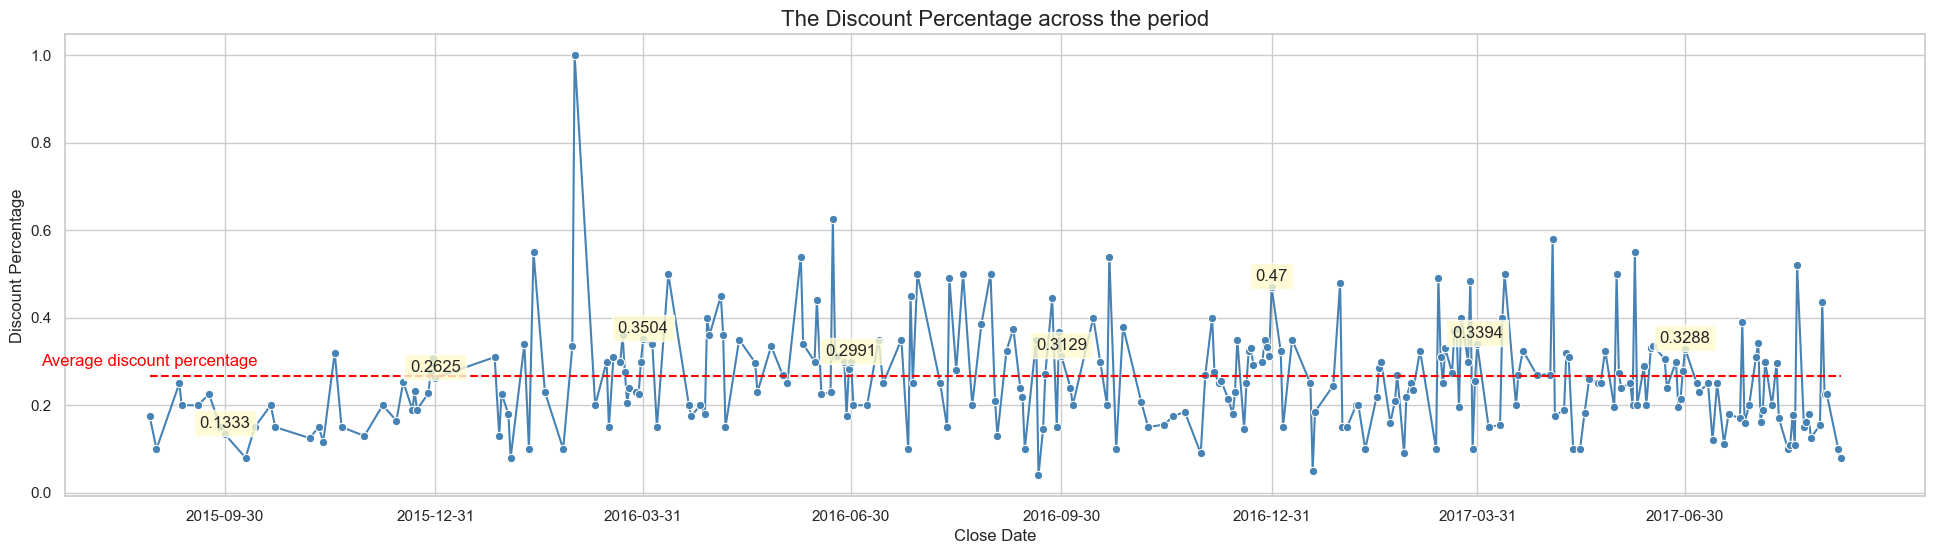

In [35]:
### plot the discount percentage across the quarters
sns.set_theme(style = 'whitegrid', palette = 'tab20')
fig, ax = plt.subplots(figsize = (24, 6))
sns.lineplot(data = df_plot[df_plot['Discount Amount'].notnull()],
             x = 'Close Date',
             y = 'Discount Percentage',
             marker = 'o',
             color = 'steelblue',
             errorbar = None)

### using last value for each quarter
bbox_props = dict(facecolor = 'lemonchiffon', alpha = 0.8)
for index, row in df_quarterly.iterrows():
    ax.text(row['Close Date'], row['Discount Percentage'] + 0.008, 
            str(row['Discount Percentage']),
            ha = 'center', 
            va = 'bottom',
            fontsize = 12,
            bbox = bbox_props)

xtick_positions = df_quarterly['Close Date']
xtick_labels = [date.strftime('%Y-%m') for date in xtick_positions]
ax.set_xticks(xtick_positions)

plt.hlines(y = np.mean(df_plot['Discount Percentage']), linestyles = 'dashed', 
           xmin = min(df_plot[df_plot['Discount Amount'].notnull()]['Close Date']), 
           xmax = max(df_plot[df_plot['Discount Amount'].notnull()]['Close Date']), colors = 'red')
ax.text(min(df_plot[df_plot['Discount Amount'].notnull()]['Close Date']), 
        0.3, 'Average discount percentage', 
        ha = 'center', 
        va = 'center', 
        fontsize = 12,
        color = 'red')
plt.title('The Discount Percentage across the period', fontsize = 16)
plt.show()

### Comment
Upon analyzing the line plot, it becomes apparent that the average discount percentage does not exhibit a significant increase towards the end of each quarter. This observation suggests that salespeople do not consistently offer deeper discounts during that time. Additionally, the discount percentages display fluctuations without any noticeable seasonal or specific pattern. In essence, the data indicates an absence of a discernible "end-of-the-quarter" effect on the discount amounts.

### Quick memo
Here is the result from the previous model:
1. Product Channel - Partner Cloud:
    - Unoptimized Improvement: -464,910.0
    - Optimized Improvement: -511,594.77

2. Product Channel - Partner Prem:
    - Unoptimized Improvement: -1,173,838.0
    - Optimized Improvement: 446,476.0

3. Product Channel - Direct Cloud:
    - Unoptimized Improvement: 77,340.0
    - Optimized Improvement: 54,248.03

4. Product Channel - Direct Prem:
    - Unoptimized Improvement: -379,737.0
    - Optimized Improvement: 722,440.45

Comparing the unoptimized and optimized improvements for each channel/product, we can see that optimization resulted in improved outcomes in all cases except for the Partner Cloud channel. Based on this analysis, the new discount strategy should focus on the following:

1. Partner Cloud: As the optimization did not result in an improved improvement (in fact, it decreased), it suggests that the previous discount strategy was already effective. Therefore, it might be prudent to maintain the existing discount approach for this channel.

2. Partner Prem: The optimized improvement in this channel showed a significant increase compared to the unoptimized scenario. Thus, the new discount strategy should aim to maintain and we should consider exploring further discounts or incentives to improve overall performance.

3. Direct Cloud: Optimization yielded a higher improvement in the optimized scenario compared to the unoptimized one. This indicates that the new discount strategy should continue to focus on this channel. 

4. Direct Prem: The optimized improvement in this channel showcased a substantial increase compared to the unoptimized improvement. To leverage this growth, the new discount strategy should prioritize the Direct Prem channel. 

In summary, the new discount strategy should focus on maintaining the existing approach for the Partner Cloud channel, while emphasizing and enhancing the strategies for the Partner Prem, Direct Cloud, and Direct Prem channels.